# Simple pair trading algorithm between GLD and GDX

GLD is an ETF designed to reflect the spot price of gold.
GDX is a basket of gold mining stocks.

## Strategy Description:

h(n): price movements of GLD and GDX should be significantly similar.

Pair trade GLD and GDX based on the modeled hedge ratio between the two. We will manually define the entry and exit thresholds for this strategy and optimize them on a testing set.

In [18]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf

In [19]:
gld2 = yf.download('GLD', start='2021-06-26', end='2022-12-23')
gld2.to_excel('gld2.xlsx')
gdx2 = yf.download('GDX', start='2021-06-26', end='2022-12-23')
gdx2.to_excel('gdx2.xlsx')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [21]:
# Using the local data, create a merged df of stock data.
gld_df = pd.read_excel('gld2.xlsx')
gdx_df = pd.read_excel('gdx2.xlsx')
df = pd.merge(gld_df, gdx_df, on='Date', suffixes=('_GLD', '_GDX'))
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.head()

,Open_GLD,High_GLD,Low_GLD,Close_GLD,Adj Close_GLD,Volume_GLD,Open_GDX,High_GDX,Low_GDX,Close_GDX,Adj Close_GDX,Volume_GDX
Date,,,,,,,,,,,,
2021-06-28,166.679993,166.910004,166.360001,166.580002,166.580002,6508900,34.320000,34.439999,33.720001,33.980000,32.840199,19354800
2021-06-29,164.339996,165.279999,164.009995,164.830002,164.830002,7451400,33.389999,33.970001,33.299999,33.639999,32.511604,15484500
2021-06-30,164.570007,166.100006,164.289993,165.630005,165.630005,7955800,33.639999,34.209999,33.500000,33.980000,32.840199,15159300
2021-07-01,166.649994,166.880005,165.500000,166.199997,166.199997,7430500,34.470001,34.520000,33.759998,33.959999,32.820866,12172200
2021-07-02,167.350006,167.720001,166.399994,167.289993,167.289993,7873600,34.389999,34.590000,34.049999,34.419998,33.265438,14496600


In [22]:
print(f'Total Days in Set: {len(df)}')

Total Days in Set: 377


In [23]:
# Create a train and test set
train = np.arange(0, 252)
test = np.arange(train.shape[0], df.shape[0])

Use the training set to determine the hedge ratio.

In [24]:
# 1. Create a model using OLS (Ordinary Least Squares) regression.
# 2. Fit the model to the training data.
# 3. Extract the hedge ratio from the model.
model = sm.OLS(df['Adj Close_GLD'].iloc[train], df['Adj Close_GDX'].iloc[train])
results = model.fit()
hedgeratio = results.params[0]
print(f'Hedge Ratio: {hedgeratio:.4f}')

Hedge Ratio: 5.2781


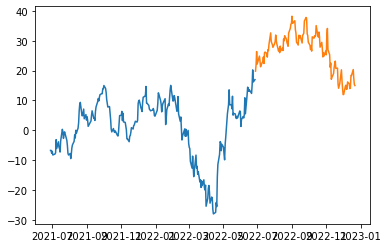

In [25]:
# spread = GLD - (hedgeratio * GDX)
spread = df.loc[:, 'Adj Close_GLD'] - hedgeratio * df.loc[:, 'Adj Close_GDX']
plt.plot(spread.iloc[train])
plt.plot(spread.iloc[test])

In [26]:
spreadmean = np.mean(spread.iloc[train])
print(f'Spread Mean: {spreadmean:.4f}')

Spread Mean: 0.8057


In [27]:
spreadstd = np.std(spread.iloc[train])
print(f'Spread Std: {spreadstd:.4f}')

Spread Std: 9.8752


In [28]:
df['zscore'] = (spread - spreadmean) / spreadstd
df['positions_GLD_Long'] = 0
df['positions_GLX_Long'] = 0
df['positions_GLD_Short'] = 0
df['positions_GLX_Short'] = 0

# Short spread
df.loc[df.zscore >= 2, ('positions_GLD_Short', 'positions_GDX_Short')] = [-1, 1]
# Exit Short spread
df.loc[df.zscore <= 1, ('positions_GLD_Short', 'positions_GDX_Short')] = 0
# Long spread
df.loc[df.zscore <= -2, ('positions_GLD_Long', 'positions_GDX_Long')] = [1, -1]
# Exit Long spread
df.loc[df.zscore >= -1, ('positions_GLD_Long', 'positions_GDX_Long')] = 0
df.head()

,Open_GLD,High_GLD,Low_GLD,Close_GLD,Adj Close_GLD,Volume_GLD,Open_GDX,High_GDX,Low_GDX,Close_GDX,Adj Close_GDX,Volume_GDX,zscore,positions_GLD_Long,positions_GLX_Long,positions_GLD_Short,positions_GLX_Short,positions_GDX_Short,positions_GDX_Long
Date,,,,,,,,,,,,,,,,,,,
2021-06-28,166.679993,166.910004,166.360001,166.580002,166.580002,6508900,34.320000,34.439999,33.720001,33.980000,32.840199,19354800,-0.765655,0,0,0,0,0.0,0.0
2021-06-29,164.339996,165.279999,164.009995,164.830002,164.830002,7451400,33.389999,33.970001,33.299999,33.639999,32.511604,15484500,-0.767238,0,0,0,0,0.0,0.0
2021-06-30,164.570007,166.100006,164.289993,165.630005,165.630005,7955800,33.639999,34.209999,33.500000,33.980000,32.840199,15159300,-0.861856,0,0,0,0,0.0,0.0
2021-07-01,166.649994,166.880005,165.500000,166.199997,166.199997,7430500,34.470001,34.520000,33.759998,33.959999,32.820866,12172200,-0.793803,0,0,0,0,0.0,0.0
2021-07-02,167.350006,167.720001,166.399994,167.289993,167.289993,7873600,34.389999,34.590000,34.049999,34.419998,33.265438,14496600,-0.921043,0,0,0,0,0.0,0.0


In [29]:
# Ensures that existing positions are carried forward unless there is an exit signal
df.fillna(method='ffill', inplace=True)

In [30]:
positions_Long = df.loc[:, ['positions_GLD_Long', 'positions_GDX_Long']]
positions_Short = df.loc[:, ['positions_GLD_Short', 'positions_GDX_Short']]
positions = np.array(positions_Long) + np.array(positions_Short)
positions = pd.DataFrame(positions, columns=['GLD', 'GDX'], index=df.index)
positions.head(20)

,GLD,GDX
Date,,
2021-06-28,0.0,0.0
2021-06-29,0.0,0.0
2021-06-30,0.0,0.0
2021-07-01,0.0,0.0
2021-07-02,0.0,0.0
2021-07-06,0.0,0.0
2021-07-07,0.0,0.0
2021-07-08,0.0,0.0
2021-07-09,0.0,0.0


In [31]:
daily_returns = df.loc[:, ['Adj Close_GLD', 'Adj Close_GDX']].pct_change()
pnl = (np.array(positions.shift()) * np.array(daily_returns)).sum(axis=1)

In [32]:
sharpe_train = np.sqrt(252) * np.mean(pnl[train[1:]]) / np.std(pnl[train[1:]])
print(f'Sharpe Ratio (Train): {sharpe_train:.4f}')

Sharpe Ratio (Train): 1.1616


In [33]:
sharpe_test = np.sqrt(252) * np.mean(pnl[test[1:]]) / np.std(pnl[test[1:]])
print(f'Sharpe Ratio (Test): {sharpe_test:.4f}')

Sharpe Ratio (Test): 0.7795


Plot the cumulative PNL sum of the strategy.

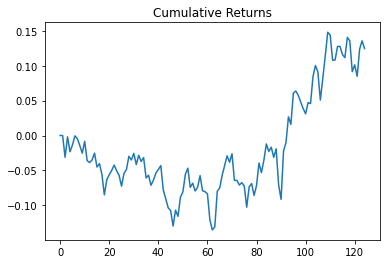

In [34]:
plt.plot(np.cumsum(pnl[test]))
plt.title('Cumulative Returns')
plt.show()